### Ques1 : Compare Scratch Time to load Dataset as compared to Pytorch's dataloader
##### Have to see how to load dataset from scratch

In [ ]:
%%capture
from __future__ import division
from __future__ import print_function

import argparse
import gzip
import os
import sys
import urllib

try:
    from urllib.error import URLError
    from urllib.request import urlretrieve
except ImportError:
    from urllib2 import URLError
    from urllib import urlretrieve

RESOURCES = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
]


def report_download_progress(chunk_number, chunk_size, file_size):
    if file_size != -1:
        percent = min(1, (chunk_number * chunk_size) / file_size)
        bar = '#' * int(64 * percent)
        sys.stdout.write('\r0% |{:<64}| {}%'.format(bar, int(percent * 100)))


def download(destination_path, url, quiet):
    if os.path.exists(destination_path):
        if not quiet:
            print('{} already exists, skipping ...'.format(destination_path))
    else:
        print('Downloading {} ...'.format(url))
        try:
            hook = None if quiet else report_download_progress
            urlretrieve(url, destination_path, reporthook=hook)
        except URLError:
            raise RuntimeError('Error downloading resource!')
        finally:
            if not quiet:
                # Just a newline.
                print()


def unzip(zipped_path, quiet):
    unzipped_path = os.path.splitext(zipped_path)[0]
    if os.path.exists(unzipped_path):
        if not quiet:
            print('{} already exists, skipping ... '.format(unzipped_path))
        return
    with gzip.open(zipped_path, 'rb') as zipped_file:
        with open(unzipped_path, 'wb') as unzipped_file:
            unzipped_file.write(zipped_file.read())
            if not quiet:
                print('Unzipped {} ...'.format(zipped_path))


def main():
    parser = argparse.ArgumentParser(
        description='Download the MNIST dataset from the internet')
    parser.add_argument(
        '-d', '--destination', default='.', help='Destination directory')
    parser.add_argument(
        '-q',
        '--quiet',
        action='store_true',
        help="Don't report about progress")
    options = parser.parse_args()

    if not os.path.exists(options.destination):
        os.makedirs(options.destination)

    try:
        for resource in RESOURCES:
            path = os.path.join(options.destination, resource)
            url = 'http://yann.lecun.com/exdb/mnist/{}'.format(resource)
            download(path, url, options.quiet)
            unzip(path, options.quiet)
    except KeyboardInterrupt:
        print('Interrupted')


if __name__ == '__main__':
    # main()
    import sys
    sys.argv = ['colab_kernel_launcher.py', '-d', '.', '-q']
    main()


In [ ]:
from PIL import Image
import numpy as np
import os

class ScratchMNISTDataset:
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self.load_data()

    def load_data(self):
        images_file = os.path.join(self.root_dir, 'train-images-idx3-ubyte')
        labels_file = os.path.join(self.root_dir, 'train-labels-idx1-ubyte')

        # Read images
        with open(images_file, 'rb') as f:
            f.read(16)  # Skip the header
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape((-1, 28, 28))

        # Read labels
        with open(labels_file, 'rb') as f:
            f.read(8)  # Skip the header
            labels = np.frombuffer(f.read(), dtype=np.uint8)

        return images, labels

    def len_custom(self):  # Change from __len__ to len_custom
        return len(self.labels)

    def get_item(self, index):  # Change from __getitem__ to get_item
        image, label = self.images[index], self.labels[index]

        # Transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, label

class ScratchDataLoader:
    def __init__(self, dataset, batch_size=128, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.current_index = 0

    def custom_iter(self):
        if self.shuffle:
            indices = np.random.permutation(self.dataset.len_custom())
        else:
            indices = np.arange(self.dataset.len_custom())

        for i in range(0, len(indices), self.batch_size):
            batch_indices = indices[i:i + self.batch_size]
            batch = [self.dataset.get_item(j) for j in batch_indices]
            yield batch

# scratch_dataset = ScratchMNISTDataset(root_dir='/content/')  # For running on google colab


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def len_custom(self):
        return len(self.dataset)

    def custom_get_item(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):  # Add this method
        return self.len_custom()

    def __getitem__(self, index):  # Add this method
        return self.custom_get_item(index)

100%|██████████| 9912422/9912422 [00:00<00:00, 111500697.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36377085.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31416020.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21143761.12it/s]


Streaming output truncated to the last 5000 lines.
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  41, 252, 252,
        252, 253, 252, 252, 252, 252, 252, 250, 144,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,  26, 157,
        202, 159, 158, 158, 117,  26, 193, 252, 239,  56,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  73,  13,   0,   0,   0,   0,  23,
         19,   0,   0,   0,   0,   0, 144, 252, 225,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  29, 233, 208,  42,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  89, 252, 225,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 205, 252, 192,  14,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  50, 235, 252, 225,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 240, 252, 214,  28,   0,   0,   0,   0,
          0,   0,   0,   0,  13,  97, 252, 252, 204

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

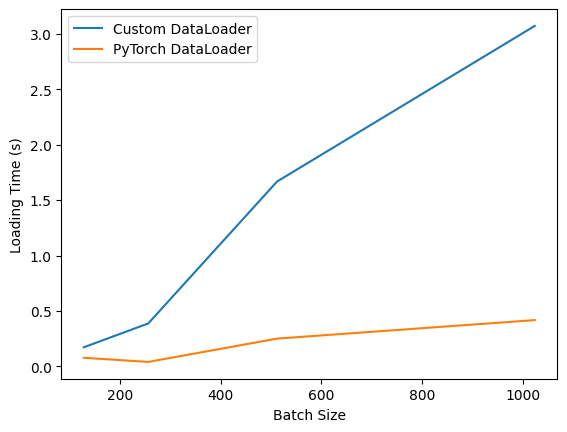

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import time
import math
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Download and normalize the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)



def measure_loading_time(dataloader):
    dataloader_iter = iter(dataloader)
    start_time = time.time()
    for data in dataloader_iter:
        print(data)
        print(f"First element of the tuple's Size: {data[0][0].shape[0]}")

        break  # Break after processing the first batch
    end_time = time.time()
    return end_time - start_time


# Define batch sizes
batch_sizes = [128, 256, 512, 1024]

# Initialize lists to store loading times
custom_loader_times = []
pytorch_loader_times = []

# Measure loading time for only no. of batch to get the whole dataset [ total time for given batch size]
for batch_size in batch_sizes:
    scratch_dataset = ScratchMNISTDataset(root_dir='/content/')  #For running on google colab
    scratch_dataloader = ScratchDataLoader(scratch_dataset, batch_size=batch_size, shuffle=True)
    custom_loading_time = measure_loading_time(scratch_dataloader.custom_iter())
    custom_loader_times.append(custom_loading_time)

    pytorch_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    pytorch_dataloader = DataLoader(CustomDataset(pytorch_dataset), batch_size=batch_size, shuffle=True)
    pytorch_loading_time = measure_loading_time(pytorch_dataloader)
    pytorch_loader_times.append(pytorch_loading_time)

# Plot the results
plt.plot(batch_sizes, custom_loader_times, label='Custom DataLoader')
plt.plot(batch_sizes, pytorch_loader_times, label='PyTorch DataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (s)')
plt.legend()
plt.show()


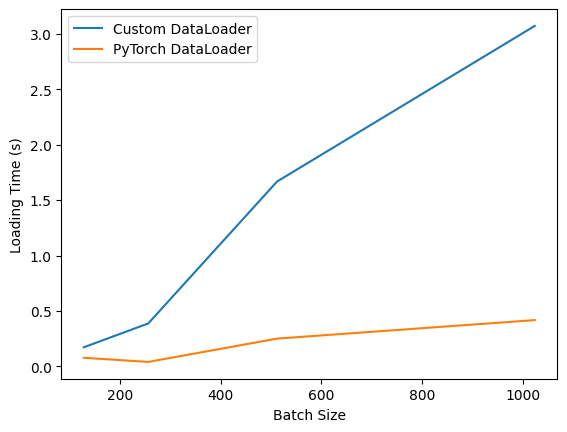

In [ ]:

plt.plot(batch_sizes, custom_loader_times, label='Custom DataLoader')
plt.plot(batch_sizes, pytorch_loader_times, label='PyTorch DataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (s)')
plt.legend()
plt.show()


##### Analysis of Graph for question 1

- Pytorch DataLoader takes much less time as compared to custom dataloader
- The increase in time in Custom Dataloader, is very high ( the rate of change of time taken with respect to batch size)
- The increase in time is much less in Pytorch Dataloader, ( the slope is very less in it case comparatively)
- Time increase with increase in size of batches, the increase is much more in custom dataloader
- Time increase in pytorch dataloader is much less in comparison to custom dataloader

------

### Question 2 : Pytorch's Neural Network with RelU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size,hidden_size)
        # self.relu5 = nn.ReLU()
        # self.fc6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        # x = self.relu5(self.fc5(x))
        # x = self.fc6(x)
        return x

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

validation_size = int(0.5 * len(test_dataset))
testing_size = len(test_dataset) - validation_size

test_dataset, val_dataset = random_split(test_dataset, [testing_size, validation_size])

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

torch.manual_seed(42)


input_size = 28 * 28
hidden_size = 300
output_size = 10
model = FeedForwardNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)

num_epochs = 60
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Testing
    model.eval()
    test_loss, correct_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_accuracy*100:.4f}, Val Acc: {val_accuracy*100:.4f}, Test Acc: {test_accuracy*100:.4f}")



Epoch 1/60: Train Loss: 5.6607, Val Loss: 5.6319, Test Loss: 5.6317, Train Acc: 5.6350, Val Acc: 10.0000, Test Acc: 10.1400
Epoch 2/60: Train Loss: 5.5957, Val Loss: 5.5537, Test Loss: 5.5532, Train Acc: 10.3517, Val Acc: 9.9400, Test Acc: 10.4200
Epoch 3/60: Train Loss: 5.4767, Val Loss: 5.3581, Test Loss: 5.3565, Train Acc: 11.0350, Val Acc: 16.5600, Test Acc: 17.5200
Epoch 4/60: Train Loss: 4.7213, Val Loss: 3.1018, Test Loss: 3.0918, Train Acc: 17.5400, Val Acc: 10.7200, Test Acc: 11.9800


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already defined train_accuracies, val_accuracies, and test_accuracies

# Multiply 100 to all accuracies
train_accuracies = [accuracy * 100 for accuracy in train_accuracies]
val_accuracies = [accuracy * 100 for accuracy in val_accuracies]
test_accuracies = [accuracy * 100 for accuracy in test_accuracies]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


##### Analysis of Ques 2 Graph

- Split the testing dataset into two equal halfs randomly ( 10% test 10% val, 80% training)
- Loss has decreased from 2.25 to 0.50 which has increased the accuracy from 9.98% to 88.8%
- Accuracy is increasing slowly and reaches a stable maximum near 88%, because of high gradient value of relu gradient
- Loss has only decreased steadily
- Hidden size 40




----

### Ques 3: Scratch Implementation for Scratch RelU

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split


In [ ]:

def manual_relu(x):
    return torch.max(torch.zeros_like(x), x)


def load_mnist():
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    x_train, y_train = mnist_train.data, mnist_train.targets
    x_test, y_test = mnist_test.data, mnist_test.targets
    x_train = (x_train.float() - 128.0) / 128.0
    x_test = (x_test.float() - 128.0) / 128.0
    x_train, x_test, y_train, y_test = train_test_split(
        torch.cat([x_train.unsqueeze(1), x_test.unsqueeze(1)]),  # Add a channel dimension
        torch.cat([y_train, y_test]),
        test_size=0.4,
        random_state=42
    )

    return x_train.squeeze(1), y_train, x_test.squeeze(1), y_test


In [ ]:

def predict(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    x = torch.tensor(x, dtype=torch.float32)

    z1 = x.mm(W1) + b1
    a1 = manual_relu(z1)
    z2 = a1.mm(W2) + b2
    a2 = manual_relu(z2)
    z3 = a2.mm(W3) + b3
    a3 = manual_relu(z3)
    z4 = a3.mm(W4) + b4
    a4 = manual_relu(z4)
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    return torch.argmax(probs, dim=1).numpy()


In [ ]:

def calculate_loss(model, X, y):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)  # Corrected here

    z1 = X.mm(W1) + b1
    a1 = manual_relu(z1)
    z2 = a1.mm(W2) + b2
    a2 = manual_relu(z2)
    z3 = a2.mm(W3) + b3
    a3 = manual_relu(z3)
    z4 = a3.mm(W4) + b4
    a4 = manual_relu(z4)
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    num_examples = X.shape[0]
    corect_logprobs = -torch.log(probs[torch.arange(num_examples), y])
    data_loss = torch.sum(corect_logprobs)

    return 1. / num_examples * data_loss.item()



In [ ]:


import torch
import torch.nn.functional as F

def build_model(X, y, X_test,Y_test, nn_hdim, epsilon,  num_passes=60, print_loss=False):
    torch.manual_seed(0)
    num_examples = X.shape[0]
    nn_input_dim = nn_hdim[0]
    print('input dim', nn_input_dim)

    hdim1, hdim2, hdim3, hdim4, hdim5 = nn_hdim[0:]

    W1 = torch.randn(nn_input_dim, hdim1, requires_grad=True) / (hdim1**0.5)
    b1 = torch.zeros(1, hdim1, requires_grad=True)

    W2 = torch.randn(hdim1, hdim2, requires_grad=True) / (hdim2**0.5)
    b2 = torch.zeros(1, hdim2, requires_grad=True)

    W3 = torch.randn(hdim2, hdim3, requires_grad=True) / (hdim3**0.5)
    b3 = torch.zeros(1, hdim3, requires_grad=True)

    W4 = torch.randn(hdim3, hdim4, requires_grad=True) / (hdim4**0.5)
    b4 = torch.zeros(1, hdim4, requires_grad=True)

    W5 = torch.randn(hdim4, hdim5, requires_grad=True) / (hdim5**0.5)
    b5 = torch.zeros(1, hdim5, requires_grad=True)

    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5 }

    bs = 64
    nbs_per_epoch = int(num_examples / bs)

    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for i in range(0, num_passes):
        j = i % nbs_per_epoch
        if j == 0:
            ridx = torch.randperm(num_examples)
            X = X[ridx, :]
            y = y[ridx]

        Xb = torch.tensor(X[j * bs:(j + 1) * bs, :], dtype=torch.float32, requires_grad=False)
        yb = torch.tensor(y[j * bs:(j + 1) * bs], dtype=torch.long, requires_grad=False)

        # Forward propagation
        z1 = Xb.mm(W1) + b1
        a1 = manual_relu(z1)
        z2 = a1.mm(W2) + b2
        a2 = manual_relu(z2)
        z3 = a2.mm(W3) + b3
        a3 = manual_relu(z3)
        z4 = a3.mm(W4) + b4
        a4 = manual_relu(z4)
        z5 = a4.mm(W5) + b5
        exp_scores = torch.exp(z5)

        # Calculating Gradients

        # Backpropagation
        delta_loss = exp_scores / exp_scores.sum(dim=1, keepdim=True)
        delta_loss[torch.arange(bs), yb] -= 1

        dW5 = a4.t().mm(  delta_loss )
        db5 = delta_loss.sum(dim=0, keepdim=True)
        delta5 = delta_loss.mm( W5.t() ) * ( a4 > 0 ).float()

        dW4 = a3.t().mm(delta5)
        db4 = delta5.sum(dim=0, keepdim=True)
        delta4 = delta5.mm(W4.t()) * ( a3 > 0 ).float()

        dW3 = a2.t().mm(delta4)
        db3 = delta4.sum(dim=0, keepdim=True)
        delta3 = delta4.mm(W3.t()) * ( a2 > 0 ).float()
        dW2 = a1.t().mm(delta3)
        db2 = delta3.sum(dim=0, keepdim=True)
        delta2 = delta3.mm(W2.t()) * ( a1 > 0 ).float()
        dW1 = Xb.t().mm(delta2)
        db1 = delta2.sum(dim=0)

# Updating the weight and bias --------------------------------------------------------------------

        W1.data -= epsilon * dW1.data
        b1.data -= epsilon * db1.data
        W2.data -= epsilon * dW2.data
        b2.data -= epsilon * db2.data
        W3.data -= epsilon * dW3.data
        b3.data -= epsilon * db3.data
        W4.data -= epsilon * dW4.data
        b4.data -= epsilon * db4.data
        W5.data -= epsilon * dW5.data
        b5.data -= epsilon * db5.data

        train_loss = calculate_loss(model, X_train, Y_train)
        y_pred_train = predict(model, X_train)
        y_pred_train_tensor = torch.tensor(y_pred_train, dtype=torch.long)  # Convert y_pred to a tensor with dtype long
        train_accuracy = torch.sum(y_pred_train_tensor == Y_train, dtype=torch.float32) / Y_train.shape[0]

        test_loss = calculate_loss(model, X_test, Y_test)
        y_pred_test = predict(model, X_test)
        y_pred_test_tensor = torch.tensor(y_pred_test, dtype=torch.long)  # Convert y_pred to a tensor with dtype long
        test_accuracy = torch.sum(y_pred_test_tensor == Y_test, dtype=torch.float32) / Y_test.shape[0]

        val_loss = calculate_loss(model, X_val, Y_val)
        y_val_pred = predict(model, X_val)
        y_val_pred_tensor = torch.tensor(y_val_pred, dtype=torch.long)
        val_accuracy = torch.sum(y_val_pred_tensor == Y_val, dtype=torch.float32) / Y_val.shape[0]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy.item() * 100)
        val_accuracies.append(val_accuracy.item() * 100)
        test_accuracies.append(test_accuracy.item() * 100)

        print("Testing Loss after iteration {}: {:.2f}, Training Loss {:.2f},Validation Loss {:.2f} ,Training accuracy: {:.2f}%, Testing accuracy: {:.2f}%, Validation accuracy: {:.2f}%"
              .format(i + 1, test_loss, train_loss, val_loss, train_accuracy.item()*100, test_accuracy.item() * 100, val_accuracy.item() * 100))

    plt.figure(figsize=(12, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy during Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model
# load
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pylab


(train_images, train_labels, test_images, test_labels) = load_mnist()
n_train, w, h = train_images.shape
X_train = torch.tensor(train_images.reshape((n_train, w * h)), dtype=torch.float32)
Y_train = torch.tensor(train_labels, dtype=torch.long)
n_test, w, h = test_images.shape
X_test = torch.tensor(test_images.reshape((n_test, w * h)), dtype=torch.float32)
Y_test = torch.tensor(test_labels, dtype=torch.long)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

num_examples, input_dim = X_train.shape
epsilon = 0.0003
# reg_lambda = 0.00

hidden_size = 1000
model = build_model(X_train, Y_train, X_test, Y_test,[input_dim, hidden_size , hidden_size, hidden_size, hidden_size], epsilon,  60, print_loss=True)

X_test0 = X_test[0:3, :]
print(X_test0)
y_pred0 = predict(model, X_test0)


#### Analysis of ques 3 graph

- The loss is not steadily decreasing
- It is increasing and decreasing but from a larger view it decreases after 2-3 iteration even if it has a spike
- Accuracy alsoo has some down spikes in between but is increasing after some epochs even if it decreases in some of the iterations
- Accuracy and Loss graphs are not smooth as Pytorch
- Hidden size in comparison to the pytorch's implementation is nearly 8 times to make accuracy 60% when it was 88% in the pytorch implementation in just 40 neuron in each layer
- Takes lesser time in 60 epochs as compared to pytorchs 60 epochs time


-----

### Question 4 : Sigmoid Implementation with Pytorch after Batch Normalization
##### Split done for train, test , validation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

# Define the neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.sigmoid4 = nn.Sigmoid()
        self.fc5 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.sigmoid1(self.bn1(self.fc1(x)))
        x = self.sigmoid2(self.bn2(self.fc2(x)))
        x = self.sigmoid3(self.bn3(self.fc3(x)))
        x = self.sigmoid4(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return torch.nn.functional.softmax(x, dim=1)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

validation_size = int(0.5 * len(test_dataset))
testing_size = len(test_dataset) - validation_size

test_dataset, val_dataset = random_split(test_dataset, [testing_size, validation_size])

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


input_size = 28 * 28
hidden_size = 400
output_size = 10
model = FeedForwardNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)
clip_value = 0.5  # Set your desired clip value

# Training loop
num_epochs = 60
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Testing
    model.eval()
    test_loss, correct_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_accuracy*100:.4f}, Val Acc: {val_accuracy*100:.4f}, Test Acc: {test_accuracy*100:.4f}")



In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already defined train_accuracies, val_accuracies, and test_accuracies
train_accuracies = [accuracy * 100 for accuracy in train_accuracies]
val_accuracies = [accuracy * 100 for accuracy in val_accuracies]
test_accuracies = [accuracy * 100 for accuracy in test_accuracies]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Analysis of Graph for Pytorch's Sigmoid Linear Neural Network

- Loss has fallen smoothly, initially the loss has fallen too much,later the loss decrease rate is lesser
- Accuracy isn't increasing steeply, the slope is too less ( because of the nature of sigmoid functions derivative
- Accuracy in 10-30th epoch is almost constant near 60% and then in some there is small increase to 67% in all three ( test, train , val)

------

### Ques 4 : Batch Normalization from scratch for Sigmoid , Neural Network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

def manual_sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def sigmoid_derivative(x):
    sigmoid_x = 1 / (1 + torch.exp(-x))
    return sigmoid_x * (1 - sigmoid_x)

def batch_norm_forward(X, gamma, beta, eps=1e-5):
    mean = torch.mean(X, dim=0, keepdim=True)
    var = torch.var(X, dim=0, keepdim=True)
    X_normalized = (X - mean) / torch.sqrt(var + eps)
    out = gamma * X_normalized + beta
    cache = (X, X_normalized, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    X, X_normalized, mean, var, gamma, beta, eps = cache

    dgamma = torch.sum(dout * X_normalized, dim=0, keepdim=True)
    dbeta = torch.sum(dout, dim=0, keepdim=True)

    dX_normalized = dout * gamma
    dvar = torch.sum(dX_normalized * (X - mean) * -0.5 * torch.pow(var + eps, -1.5), dim=0, keepdim=True)
    dmean = torch.sum(dX_normalized * -1 / torch.sqrt(var + eps), dim=0, keepdim=True) + dvar * torch.sum(-2 * (X - mean), dim=0, keepdim=True) / X.size(0)
    dX = dX_normalized / torch.sqrt(var + eps) + dvar * 2 * (X - mean) / X.size(0) + dmean / X.size(0)

    return dX, dgamma, dbeta

def calculate_loss(model, X, y, reg_lambda=0.00):
    W1, b1, gamma1, beta1, W2, b2, gamma2, beta2, W3, b3, gamma3, beta3, W4, b4, gamma4, beta4, W5, b5, gamma5, beta5 = model.values()

    z1_bn, cache_bn1 = batch_norm_forward(X.mm(W1) + b1, gamma1, beta1)
    a1 = manual_sigmoid(z1_bn)
    z2_bn, cache_bn2 = batch_norm_forward(a1.mm(W2) + b2, gamma2, beta2)
    a2 = manual_sigmoid(z2_bn)
    z3_bn, cache_bn3 = batch_norm_forward(a2.mm(W3) + b3, gamma3, beta3)
    a3 = manual_sigmoid(z3_bn)
    z4_bn, cache_bn4 = batch_norm_forward(a3.mm(W4) + b4, gamma4, beta4)
    a4 = manual_sigmoid(z4_bn)
    z5_bn, cache_bn5 = batch_norm_forward(a4.mm(W5) + b5, gamma5, beta5)
    exp_scores = torch.exp(z5_bn)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    num_examples = X.shape[0]
    corect_logprobs = -torch.log(probs[torch.arange(num_examples), y])
    data_loss = torch.sum(corect_logprobs)

    # Add regularization term
    reg_loss = 0.5 * reg_lambda * (torch.sum(W1**2) + torch.sum(W2**2) + torch.sum(W3**2) + torch.sum(W4**2) + torch.sum(W5**2))
    data_loss += reg_loss

    return 1. / num_examples * data_loss.item()

def predict(model, X):
    W1, b1, gamma1, beta1, W2, b2, gamma2, beta2, W3, b3, gamma3, beta3, W4, b4, gamma4, beta4, W5, b5, gamma5, beta5 = \
        model.values()

    z1_bn, _ = batch_norm_forward(X.mm(W1) + b1, gamma1, beta1)
    a1 = manual_sigmoid(z1_bn)
    z2_bn, _ = batch_norm_forward(a1.mm(W2) + b2, gamma2, beta2)
    a2 = manual_sigmoid(z2_bn)
    z3_bn, _ = batch_norm_forward(a2.mm(W3) + b3, gamma3, beta3)
    a3 = manual_sigmoid(z3_bn)
    z4_bn, _ = batch_norm_forward(a3.mm(W4) + b4, gamma4, beta4)
    a4 = manual_sigmoid(z4_bn)
    z5_bn, _ = batch_norm_forward(a4.mm(W5) + b5, gamma5, beta5)
    exp_scores = torch.exp(z5_bn)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    return torch.argmax(probs, dim=1).numpy()

def build_model(X, y, X_test, Y_test, nn_hdim, epsilon, reg_lambda, num_passes=60, print_loss=False, use_batch_norm=True):
    torch.manual_seed(0)
    num_examples = X.shape[0]
    nn_input_dim = nn_hdim[0]

    hdim1, hdim2, hdim3, hdim4, hdim5 = nn_hdim[1:]
    W1 = torch.randn(nn_input_dim, hdim1, requires_grad=True) / (hdim1**0.5)
    b1 = torch.zeros(1, hdim1, requires_grad=True)

    W2 = torch.randn(hdim1, hdim2, requires_grad=True) / (hdim2**0.5)
    b2 = torch.zeros(1, hdim2, requires_grad=True)

    W3 = torch.randn(hdim2, hdim3, requires_grad=True) / (hdim3**0.5)
    b3 = torch.zeros(1, hdim3, requires_grad=True)

    W4 = torch.randn(hdim3, hdim4, requires_grad=True) / (hdim4**0.5)
    b4 = torch.zeros(1, hdim4, requires_grad=True)

    W5 = torch.randn(hdim4, hdim5, requires_grad=True) / (hdim5**0.5)
    b5 = torch.zeros(1, hdim5, requires_grad=True)

    # W1 = torch.randn(nn_input_dim, hdim1, requires_grad=True) * (2.0 / (nn_input_dim + hdim1))**0.5
    # b1 = torch.zeros(1, hdim1, requires_grad=True)
    gamma1 = torch.ones(1, hdim1, requires_grad=True)
    beta1 = torch.zeros(1, hdim1, requires_grad=True)

    # W2 = torch.randn(hdim1, hdim2, requires_grad=True) * (2.0 / (hdim1 + hdim2))**0.5
    # b2 = torch.zeros(1, hdim2, requires_grad=True)
    gamma2 = torch.ones(1, hdim2, requires_grad=True)
    beta2 = torch.zeros(1, hdim2, requires_grad=True)

    # W3 = torch.randn(hdim2, hdim3, requires_grad=True) * (2.0 / (hdim2 + hdim3))**0.5
    # b3 = torch.zeros(1, hdim3, requires_grad=True)
    gamma3 = torch.ones(1, hdim3, requires_grad=True)
    beta3 = torch.zeros(1, hdim3, requires_grad=True)

    # W4 = torch.randn(hdim3, hdim4, requires_grad=True) * (2.0 / (hdim3 + hdim4))**0.5
    # b4 = torch.zeros(1, hdim4, requires_grad=True)
    gamma4 = torch.ones(1, hdim4, requires_grad=True)
    beta4 = torch.zeros(1, hdim4, requires_grad=True)

    # W5 = torch.randn(hdim4, hdim5, requires_grad=True) * (2.0 / (hdim4 + hdim5))**0.5
    # b5 = torch.zeros(1, hdim5, requires_grad=True)
    gamma5 = torch.ones(1, hdim5, requires_grad=True)
    beta5 = torch.zeros(1, hdim5, requires_grad=True)

    model = {
        'W1': W1, 'b1': b1, 'gamma1': gamma1, 'beta1': beta1,
        'W2': W2, 'b2': b2, 'gamma2': gamma2, 'beta2': beta2,
        'W3': W3, 'b3': b3, 'gamma3': gamma3, 'beta3': beta3,
        'W4': W4, 'b4': b4, 'gamma4': gamma4, 'beta4': beta4,
        'W5': W5, 'b5': b5, 'gamma5': gamma5, 'beta5': beta5
    }

    bs = 64
    nbs_per_epoch = int(num_examples / bs)

    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for i in range(0, num_passes):
        j = i % nbs_per_epoch
        if j == 0:
            ridx = torch.randperm(num_examples)
            X = X[ridx, :]
            y = y[ridx]

        Xb = torch.tensor(X[j * bs:(j + 1) * bs, :], dtype=torch.float32, requires_grad=False)
        yb = torch.tensor(y[j * bs:(j + 1) * bs], dtype=torch.long, requires_grad=False)

        # Forward pass
        z1_bn, cache_bn1 = batch_norm_forward(Xb.mm(W1) + b1, gamma1, beta1)
        a1 = manual_sigmoid(z1_bn)
        z2_bn, cache_bn2 = batch_norm_forward(a1.mm(W2) + b2, gamma2, beta2)
        a2 = manual_sigmoid(z2_bn)
        z3_bn, cache_bn3 = batch_norm_forward(a2.mm(W3) + b3, gamma3, beta3)
        a3 = manual_sigmoid(z3_bn)
        z4_bn, cache_bn4 = batch_norm_forward(a3.mm(W4) + b4, gamma4, beta4)
        a4 = manual_sigmoid(z4_bn)
        z5_bn, cache_bn5 = batch_norm_forward(a4.mm(W5) + b5, gamma5, beta5)
        exp_scores = torch.exp(z5_bn)

        delta_loss = exp_scores / exp_scores.sum(dim=1, keepdim=True)
        delta_loss[torch.arange(bs), yb] -= 1

        # Backward pass
        delta5_bn, dgamma5, dbeta5 = batch_norm_backward(delta_loss, cache_bn5)
        delta4_bn, dgamma4, dbeta4 = batch_norm_backward(delta5_bn, cache_bn4)
        delta3_bn, dgamma3, dbeta3 = batch_norm_backward(delta4_bn, cache_bn3)
        delta2_bn, dgamma2, dbeta2 = batch_norm_backward(delta3_bn, cache_bn2)
        delta1_bn, dgamma1, dbeta1 = batch_norm_backward(delta2_bn, cache_bn1)

        dW5 = a4.t().mm(delta5_bn)
        db5 = delta5_bn.sum(dim=0, keepdim=True)
        dgamma5_sum = torch.sum(dgamma5, dim=0, keepdim=True)
        dbeta5_sum = torch.sum(dbeta5, dim=0, keepdim=True)
        delta5 = delta5_bn.mm(W5.t()) * (a4) * (1 - a4)

        dW4 = a3.t().mm(delta4_bn)
        db4 = delta4_bn.sum(dim=0, keepdim=True)
        dgamma4_sum = torch.sum(dgamma4, dim=0, keepdim=True)
        dbeta4_sum = torch.sum(dbeta4, dim=0, keepdim=True)
        delta4 = delta4_bn.mm(W4.t()) * (a3) * (1 - a3)

        dW3 = a2.t().mm(delta3_bn)
        db3 = delta3_bn.sum(dim=0, keepdim=True)
        dgamma3_sum = torch.sum(dgamma3, dim=0, keepdim=True)
        dbeta3_sum = torch.sum(dbeta3, dim=0, keepdim=True)
        delta3 = delta3_bn.mm(W3.t()) * (a2) * (1 - a2)

        dW2 = a1.t().mm(delta2_bn)
        db2 = delta2_bn.sum(dim=0, keepdim=True)
        dgamma2_sum = torch.sum(dgamma2, dim=0, keepdim=True)
        dbeta2_sum = torch.sum(dbeta2, dim=0, keepdim=True)
        delta2 = delta2_bn.mm(W2.t()) * (a1) * (1 - a1)

        dW1 = Xb.t().mm(delta1_bn)
        db1 = delta1_bn.sum(dim=0)
        dgamma1_sum = torch.sum(dgamma1, dim=0, keepdim=True)
        dbeta1_sum = torch.sum(dbeta1, dim=0, keepdim=True)
        delta1 = delta1_bn.mm(W1.t()) * (Xb) * (1 - Xb)

        # Update weights and biases
        W1.data -= epsilon * (dW1.data + reg_lambda * W1.data)
        b1.data -= epsilon * db1.data
        gamma1.data -= epsilon * dgamma1_sum.data
        beta1.data -= epsilon * dbeta1_sum.data

        W2.data -= epsilon * (dW2.data + reg_lambda * W2.data)
        b2.data -= epsilon * db2.data
        gamma2.data -= epsilon * dgamma2_sum.data
        beta2.data -= epsilon * dbeta2_sum.data

        W3.data -= epsilon * (dW3.data + reg_lambda * W3.data)
        b3.data -= epsilon * db3.data
        gamma3.data -= epsilon * dgamma3_sum.data
        beta3.data -= epsilon * dbeta3_sum.data

        W4.data -= epsilon * (dW4.data + reg_lambda * W4.data)
        b4.data -= epsilon * db4.data
        gamma4.data -= epsilon * dgamma4_sum.data
        beta4.data -= epsilon * dbeta4_sum.data

        W5.data -= epsilon * (dW5.data + reg_lambda * W5.data)
        b5.data -= epsilon * db5.data
        gamma5.data -= epsilon * dgamma5_sum.data
        beta5.data -= epsilon * dbeta5_sum.data

        # Calculate training, validation, and test loss and accuracy
        train_loss = calculate_loss(model, X_train, Y_train)
        y_pred_train = predict(model, X_train)
        y_pred_train_tensor = torch.tensor(y_pred_train, dtype=torch.long)
        train_accuracy = torch.sum(y_pred_train_tensor == Y_train, dtype=torch.float32) / Y_train.shape[0]

        test_loss = calculate_loss(model, X_test, Y_test)
        y_pred_test = predict(model, X_test)
        y_pred_test_tensor = torch.tensor(y_pred_test, dtype=torch.long)
        test_accuracy = torch.sum(y_pred_test_tensor == Y_test, dtype=torch.float32) / Y_test.shape[0]

        val_loss = calculate_loss(model, X_val, Y_val)
        y_val_pred = predict(model, X_val)
        y_val_pred_tensor = torch.tensor(y_val_pred, dtype=torch.long)
        val_accuracy = torch.sum(y_val_pred_tensor == Y_val, dtype=torch.float32) / Y_val.shape[0]

        # Append results for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy.item() * 100)
        val_accuracies.append(val_accuracy.item() * 100)
        test_accuracies.append(test_accuracy.item() * 100)

        # Print results
        print("Testing Loss after iteration {}: {:.2f}, Training Loss {:.2f}, Validation Loss {:.2f}, Training accuracy: {:.2f}%, Testing accuracy: {:.2f}%, Validation accuracy: {:.2f}%"
              .format(i + 1, test_loss, train_loss, val_loss, train_accuracy.item()*100, test_accuracy.item() * 100, val_accuracy.item() * 100))

    # Plotting Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy during Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

(train_images, train_labels, test_images, test_labels) = load_mnist()
n_train, w, h = train_images.shape
X_train = torch.tensor(train_images.reshape((n_train, w * h)), dtype=torch.float32)
Y_train = torch.tensor(train_labels, dtype=torch.long)
n_test, w, h = test_images.shape
X_test = torch.tensor(test_images.reshape((n_test, w * h)), dtype=torch.float32)
Y_test = torch.tensor(test_labels, dtype=torch.long)

num_examples, input_dim = X_train.shape
epsilon = 0.0003
reg_lambda = 0.00
hidden_size = 500

model = build_model(X_train, Y_train, X_test, Y_test, [input_dim, hidden_size, hidden_size, hidden_size, hidden_size, hidden_size], epsilon, reg_lambda, 60, print_loss=True, use_batch_norm=True)

# Test output
X_test0 = X_test[0:3, :]
print(X_test0)
y_pred0 = predict(model, X_test0)
# print(y_pred0)


#### Analysis of Graph:
- The loss is steadily decreasing and the accuracy is steadily increasing
- The decrease in loss per iteration is very less
- The increase in accuracy per iteration is also very less

### Question 4: Neural Network without BN, using Pytorch's Sigmoid

Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split


FeedForwardNN

In [ ]:

# Define the neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.sigmoid2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.sigmoid3 = nn.Sigmoid()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.sigmoid4 = nn.Sigmoid()
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.sigmoid1(self.fc1(x))
        x = self.sigmoid2(self.fc2(x))
        x = self.sigmoid3(self.fc3(x))
        x = self.sigmoid4(self.fc4(x))
        # x = self.sigmoid5(self.fc5(x))
        x = self.fc5(x)
        return torch.nn.functional.softmax(x, dim=1)


Training Loop

In [ ]:


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

validation_size = int(0.5 * len(test_dataset))
testing_size = len(test_dataset) - validation_size

test_dataset, val_dataset = random_split(test_dataset, [testing_size, validation_size])

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

torch.manual_seed(42)

# Initialize the model, loss function, and optimizer
input_size = 28 * 28
hidden_size = 400
output_size = 10
model = FeedForwardNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)

# Training loop
num_epochs = 60
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct_val = 0, 0

    with torch.no_grad():
      for inputs, labels in val_loader:  # Use val_loader for validation
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Testing
    model.eval()
    test_loss, correct_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_test / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, "
          f"Train Acc: {train_accuracy*100:.4f}, Val Acc: {val_accuracy*100:.4f}, Test Acc: {test_accuracy*100:.4f}")

# Plotting graphs


In [ ]:
import matplotlib.pyplot as plt

train_accuracies = [accuracy * 100 for accuracy in train_accuracies]
val_accuracies = [accuracy * 100 for accuracy in val_accuracies]
test_accuracies = [accuracy * 100 for accuracy in test_accuracies]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.plot(test_losses, label='Test')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Analysis of Graph


- Loss for train, test , and val is constantly decreasing
- Accuracy increased from 10.25 to 12% and remains constant due to nearly constant derivative of sigmoid and its nature
- With a standard Sigmoid activation, the gradient of the Sigmoid is typically some fraction between 0 and 1. If you have many layers, they multiply, and might give an overall gradient that is exponentially small, so each step of gradient descent will make only a tiny change to the weights, leading to slow convergence
- Although loss significantly went down from 5.69 to 2.39 and the accuracy has been stuck between 10-11% with lots of spikes in between is because of the nature of update step in gradient , low lr and very less decrease or increase in step

Overall gradient that is exponentially small, so each step of gradient descent will make only a tiny change to the weights, leading to slow convergence

---------


### Question 4: Neural Network without BN, Sigmoid Activation by scratch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:


def manual_sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def sigmoid_derivative(x):
    sigmoid_x = 1 / (1 + torch.exp(-x))
    return sigmoid_x * (1 - sigmoid_x)


In [ ]:
def load_mnist():
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    x_train, y_train = mnist_train.data, mnist_train.targets
    x_test, y_test = mnist_test.data, mnist_test.targets

    x_train = (x_train.float() - 128.0) / 128.0
    x_test = (x_test.float() - 128.0) / 128.0

    x_train, x_test, y_train, y_test = train_test_split(
        torch.cat([x_train.unsqueeze(1), x_test.unsqueeze(1)]),
        torch.cat([y_train, y_test]),
        test_size=0.4,
        random_state=42
    )

    return x_train.squeeze(1), y_train, x_test.squeeze(1), y_test


In [ ]:


def calculate_loss(model, X, y):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    z1 = X.mm(W1) + b1
    a1 = manual_sigmoid(z1)
    z2 = a1.mm(W2) + b2
    a2 = manual_sigmoid(z2)
    z3 = a2.mm(W3) + b3
    a3 = manual_sigmoid(z3)
    z4 = a3.mm(W4) + b4
    a4 = manual_sigmoid(z4)
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    num_examples = X.shape[0]
    corect_logprobs = -torch.log(probs[torch.arange(num_examples), y])
    data_loss = torch.sum(corect_logprobs)

    return 1. / num_examples * data_loss.item()

In [ ]:

def predict(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = \
        model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], \
        model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    x = torch.tensor(x, dtype=torch.float32)

    z1 = x.mm(W1) + b1
    a1 = manual_sigmoid(z1)
    z2 = a1.mm(W2) + b2
    a2 = manual_sigmoid(z2)
    z3 = a2.mm(W3) + b3
    a3 = manual_sigmoid(z3)
    z4 = a3.mm(W4) + b4
    a4 = manual_sigmoid(z4)
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)

    return torch.argmax(probs, dim=1).numpy()


Build Model

In [ ]:


def build_model(X, y, X_test,Y_test, nn_hdim, epsilon, reg_lambda, num_passes=60, print_loss=False):
    torch.manual_seed(0)
    num_examples = X.shape[0]
    nn_input_dim = nn_hdim[0]
    print('input dim', nn_input_dim)

    hdim1, hdim2, hdim3, hdim4, hdim5 = nn_hdim[0:]

    W1 = torch.randn(nn_input_dim, hdim1, requires_grad=True) / (hdim1**0.5)
    b1 = torch.zeros(1, hdim1, requires_grad=True)

    W2 = torch.randn(hdim1, hdim2, requires_grad=True) / (hdim2**0.5)
    b2 = torch.zeros(1, hdim2, requires_grad=True)

    W3 = torch.randn(hdim2, hdim3, requires_grad=True) / (hdim3**0.5)
    b3 = torch.zeros(1, hdim3, requires_grad=True)

    W4 = torch.randn(hdim3, hdim4, requires_grad=True) / (hdim4**0.5)
    b4 = torch.zeros(1, hdim4, requires_grad=True)

    W5 = torch.randn(hdim4, hdim5, requires_grad=True) / (hdim5**0.5)
    b5 = torch.zeros(1, hdim5, requires_grad=True)


    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,
             'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}

    bs = 64  # Batch size
    nbs_per_epoch = int(num_examples / bs)

    # initialised validation part over here

    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

    train_losses = []
    val_losses = []
    test_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    for i in range(0, num_passes):
        j = i % nbs_per_epoch
        if j == 0:
            ridx = torch.randperm(num_examples)
            X = X[ridx, :]
            y = y[ridx]

        Xb = torch.tensor(X[j * bs:(j + 1) * bs, :], dtype=torch.float32, requires_grad=False)
        yb = torch.tensor(y[j * bs:(j + 1) * bs], dtype=torch.long, requires_grad=False)

        # Forward propagation
        z1 = Xb.mm(W1) + b1
        a1 = manual_sigmoid(z1)
        z2 = a1.mm(W2) + b2
        a2 = manual_sigmoid(z2)
        z3 = a2.mm(W3) + b3
        a3 = manual_sigmoid(z3)
        z4 = a3.mm(W4) + b4
        a4 = manual_sigmoid(z4)
        z5 = a4.mm(W5) + b5
        exp_scores = torch.exp(z5)

        # Backpropagation
        delta_loss = exp_scores / exp_scores.sum(dim=1, keepdim=True)
        delta_loss[torch.arange(bs), yb] -= 1

        dW5 = a4.t().mm(delta_loss)
        db5 = delta_loss.sum(dim=0, keepdim=True)
        delta5 = delta_loss.mm(W5.t()) * (a4 )*( 1 - a4 )

        dW4 = a3.t().mm(delta5)
        db4 = delta5.sum(dim=0, keepdim=True)
        delta4 = delta5.mm(W4.t()) * (a3 )*( 1 - a3)

        dW3 = a2.t().mm(delta4)
        db3 = delta4.sum(dim=0, keepdim=True)
        delta3 = delta4.mm(W3.t()) * (a2 )*( 1 - a2)
        dW2 = a1.t().mm(delta3)
        db2 = delta3.sum(dim=0, keepdim=True)
        delta2 = delta3.mm(W2.t()) * (a1 )*( 1 - a1 )
        dW1 = Xb.t().mm(delta2)
        db1 = delta2.sum(dim=0)

        # Update weights and biases

        ## it is updating

        W1.data -= epsilon * dW1.data
        b1.data -= epsilon * db1.data
        W2.data -= epsilon * dW2.data
        b2.data -= epsilon * db2.data
        W3.data -= epsilon * dW3.data
        b3.data -= epsilon * db3.data
        W4.data -= epsilon * dW4.data
        b4.data -= epsilon * db4.data
        W5.data -= epsilon * dW5.data
        b5.data -= epsilon * db5.data
        # updates are done

        train_loss = calculate_loss(model, X_train, Y_train)
        y_pred_train = predict(model, X_train)
        y_pred_train_tensor = torch.tensor(y_pred_train, dtype=torch.long)  # Convert y_pred to a tensor with dtype long
        train_accuracy = torch.sum(y_pred_train_tensor == Y_train, dtype=torch.float32) / Y_train.shape[0]
# train loss and accuracy done

        test_loss = calculate_loss(model, X_test, Y_test)
        y_pred_test = predict(model, X_test)
        y_pred_test_tensor = torch.tensor(y_pred_test, dtype=torch.long)  # Convert y_pred to a tensor with dtype long
        test_accuracy = torch.sum(y_pred_test_tensor == Y_test, dtype=torch.float32) / Y_test.shape[0]

        val_loss = calculate_loss(model, X_val, Y_val)
        y_val_pred = predict(model, X_val)
        y_val_pred_tensor = torch.tensor(y_val_pred, dtype=torch.long)
        val_accuracy = torch.sum(y_val_pred_tensor == Y_val, dtype=torch.float32) / Y_val.shape[0]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy.item() * 100)
        val_accuracies.append(val_accuracy.item() * 100)
        test_accuracies.append(test_accuracy.item() * 100)

        print("Testing Loss after iteration {}: {:.2f}, Training Loss {:.2f},Validation Loss {:.2f} ,Training accuracy: {:.2f}%, Testing accuracy: {:.2f}%, Validation accuracy: {:.2f}%"
              .format(i + 1, test_loss, train_loss, val_loss, train_accuracy.item()*100, test_accuracy.item() * 100, val_accuracy.item() * 100))

    plt.figure(figsize=(12, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy during Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:

# load
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pylab


(train_images, train_labels, test_images, test_labels) = load_mnist()
n_train, w, h = train_images.shape
X_train = torch.tensor(train_images.reshape((n_train, w * h)), dtype=torch.float32)
Y_train = torch.tensor(train_labels, dtype=torch.long)
n_test, w, h = test_images.shape
X_test = torch.tensor(test_images.reshape((n_test, w * h)), dtype=torch.float32)
Y_test = torch.tensor(test_labels, dtype=torch.long)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# Normalize data

num_examples, input_dim = X_train.shape
epsilon = 0.0003
reg_lambda = 0.00

# Assuming build_model and predict functions are defined accordingly for PyTorch
hidden_size = 500
model = build_model(X_train, Y_train, X_test, Y_test,[input_dim, hidden_size, hidden_size, hidden_size, hidden_size], epsilon, reg_lambda, 60, print_loss=True)

# Test output
X_test0 = X_test[0:3, :]
print(X_test0)
y_pred0 = predict(model, X_test0)
# print(y_pred0)


#### Analysis of Graph

https://wandb.ai/ayush-thakur/dl-question-bank/reports/ReLU-vs-Sigmoid-Function-in-Deep-Neural-Networks--VmlldzoyMDk0MzI

The model trained with ReLU converged quickly and thus takes much less time when compared to models trained on the Sigmoid function.
- Gradients are not increasing much because of , derivative to be very close to 0.
- With a standard Sigmoid activation, the gradient of the Sigmoid is typically some fraction between 0 and 1. If you have many layers, they multiply, and might give an overall gradient that is exponentially small, so each step of gradient descent will make only a tiny change to the weights, leading to slow convergence
- Although loss significantly went down from 5.69 to 2.39 and the accuracy has been stuck between 10-11% with lots of spikes in between is because of the nature of update step in gradient , low lr and very less decrease or increase in step

Overall gradient that is exponentially small, so each step of gradient descent will make only a tiny change to the weights, leading to slow convergence

### Question 4: Neural Network With BN

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

torch.manual_seed(0)

def manual_sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def initialize_weights_with_bn(nn_hdim):
    hdim1, hdim2, hdim3, hdim4, hdim5 = nn_hdim[1:]
    nn_input_dim = 784

    # batch normalization parameters
    bn1 = torch.nn.BatchNorm1d(hdim1, affine=False)  # BatchNorm without learnable parameters
    bn2 = torch.nn.BatchNorm1d(hdim2, affine=False)
    bn3 = torch.nn.BatchNorm1d(hdim3, affine=False)
    bn4 = torch.nn.BatchNorm1d(hdim4, affine=False)
    bn5 = torch.nn.BatchNorm1d(hdim5, affine=False)
    # initialize weights and biases
    W1 = torch.randn(nn_input_dim, hdim1, requires_grad=True) / (hdim1 ** 0.5)
    b1 = torch.zeros(1, hdim1, requires_grad=True)
    W2 = torch.randn(hdim1, hdim2, requires_grad=True) / (hdim2 ** 0.5)
    b2 = torch.zeros(1, hdim2, requires_grad=True)
    W3 = torch.randn(hdim2, hdim3, requires_grad=True) / (hdim3 ** 0.5)
    b3 = torch.zeros(1, hdim3, requires_grad=True)
    W4 = torch.randn(hdim3, hdim4, requires_grad=True) / (hdim4 ** 0.5)
    b4 = torch.zeros(1, hdim4, requires_grad=True)
    W5 = torch.randn(hdim4, hdim5, requires_grad=True) / (hdim5 ** 0.5)
    b5 = torch.zeros(1, hdim5, requires_grad=True)

    return W1, b1, bn1, W2, b2, bn2, W3, b3, bn3, W4, b4, bn4, W5, b5, bn5


def forward_pass(X, model):
    W1, b1, bn1, W2, b2, bn2, W3, b3, bn3, W4, b4, bn4, W5, b5, bn5 = model.values()
    z1 = X.mm(W1) + b1
    a1 = manual_sigmoid(bn1(z1))  # batch normalization and sigmoid activation
    z2 = a1.mm(W2) + b2
    a2 = manual_sigmoid(bn2(z2))
    z3 = a2.mm(W3) + b3
    a3 = manual_sigmoid(bn3(z3))
    z4 = a3.mm(W4) + b4
    a4 = manual_sigmoid(bn4(z4))
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    return exp_scores


def calculate_loss(model, X, y):
    exp_scores = forward_pass(X, model)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    num_examples = X.shape[0]
    corect_logprobs = -torch.log(probs[torch.arange(num_examples), y])
    data_loss = torch.sum(corect_logprobs)
    return 1. / num_examples * data_loss.item()

def predict(model, X):
    exp_scores = forward_pass(X, model)
    probs = exp_scores / torch.sum(exp_scores, dim=1, keepdim=True)
    return torch.argmax(probs, dim=1).numpy()


mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_train, y_train = mnist_train.data, mnist_train.targets
X_test, y_test = mnist_test.data, mnist_test.targets

from torch.utils.data import TensorDataset, random_split
train_dataset = TensorDataset(X_train, y_train)
validation_size = int(0.2 * len(train_dataset))
training_size = len(train_dataset) - validation_size
train_set, val_set = random_split(train_dataset, [training_size, validation_size])

X_train, y_train = train_set.dataset.tensors
X_val, y_val = val_set.dataset.tensors

X_train = (X_train.float() - 128.0) / 128.0
X_test = (X_test.float() - 128.0) / 128.0
X_val = (X_val.float() - 128.0) / 128.0

x_train, x_test, y_train, y_test = train_test_split(torch.cat([X_train.unsqueeze(1), X_test.unsqueeze(1)]), torch.cat([y_train, y_test]), test_size=0.4, random_state=42)

(train_images, train_labels, test_images, test_labels) = x_train.squeeze(1), y_train, x_test.squeeze(1), y_test

n_train, w, h = train_images.shape
X_train = torch.tensor(train_images.reshape((n_train, w * h)), dtype=torch.float32)
Y_train = torch.tensor(train_labels, dtype=torch.long)

n_test, w, h = test_images.shape
X_test = torch.tensor(test_images.reshape((n_test, w * h)), dtype=torch.float32)
Y_test = torch.tensor(test_labels, dtype=torch.long)

n_val, _, _ = X_val.shape
X_val = torch.tensor(X_val.reshape((n_val, w * h)), dtype=torch.float32)
Y_val = torch.tensor(y_val, dtype=torch.long)


# Build model with Batch Normalization
num_passes = 60
batch_size = 128
epsilon = 0.0003
hidden_size = 200
X, y = X_train, Y_train
nn_hdim = [784, hidden_size, hidden_size, hidden_size, hidden_size, 10]

(W1, b1, bn1, W2, b2, bn2, W3, b3, bn3, W4, b4, bn4, W5, b5, bn5) = initialize_weights_with_bn(nn_hdim)
model = {'W1': W1, 'b1': b1, 'bn1': bn1, 'W2': W2, 'b2': b2, 'bn2': bn2,
         'W3': W3, 'b3': b3, 'bn3': bn3, 'W4': W4, 'b4': b4, 'bn4': bn4,
         'W5': W5, 'b5': b5, 'bn5': bn5}

nbs_per_epoch = int(X.shape[0] / batch_size)

train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

for i in range(0, num_passes):
    j = i % nbs_per_epoch
    if j == 0:
        ridx = torch.randperm(X.shape[0])
        X = X[ridx, :]
        y = y[ridx]
    Xb = torch.tensor(X[j * batch_size:(j + 1) * batch_size, :], dtype=torch.float32, requires_grad=False)
    yb = torch.tensor(y[j * batch_size:(j + 1) * batch_size], dtype=torch.long, requires_grad=False)

    # Forward Pass
    z1 = Xb.mm(W1) + b1
    a1 = manual_sigmoid(bn1(z1))  # batch normalization and sigmoid activation
    z2 = a1.mm(W2) + b2
    a2 = manual_sigmoid(bn2(z2))
    z3 = a2.mm(W3) + b3
    a3 = manual_sigmoid(bn3(z3))
    z4 = a3.mm(W4) + b4
    a4 = manual_sigmoid(bn4(z4))
    z5 = a4.mm(W5) + b5
    exp_scores = torch.exp(z5)

    # Back propogation
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5']

    delta_loss = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    delta_loss[torch.arange(batch_size), yb] -= 1
    dW5 = a4.t().mm(delta_loss)
    db5 = delta_loss.sum(dim=0, keepdim=True)
    delta5 = delta_loss.mm(W5.t()) * sigmoid_derivative(a4)
    dW4 = a3.t().mm(delta5)
    db4 = delta5.sum(dim=0, keepdim=True)
    delta4 = delta5.mm(W4.t()) * sigmoid_derivative(a3)
    dW3 = a2.t().mm(delta4)
    db3 = delta4.sum(dim=0, keepdim=True)
    delta3 = delta4.mm(W3.t()) * sigmoid_derivative(a2)
    dW2 = a1.t().mm(delta3)
    db2 = delta3.sum(dim=0, keepdim=True)
    delta2 = delta3.mm(W2.t()) * sigmoid_derivative(a1)
    dW1 = Xb.t().mm(delta2)
    db1 = delta2.sum(dim=0)


    # Update weights and bias
    W1.data -= epsilon * dW1.data
    b1.data -= epsilon * db1.data
    W2.data -= epsilon * dW2.data
    b2.data -= epsilon * db2.data
    W3.data -= epsilon * dW3.data
    b3.data -= epsilon * db3.data
    W4.data -= epsilon * dW4.data
    b4.data -= epsilon * db4.data
    W5.data -= epsilon * dW5.data
    b5.data -= epsilon * db5.data

    # Calculate Loss
    train_loss = calculate_loss(model, X_train, Y_train)
    y_pred_train = predict(model, X_train)
    y_pred_train_tensor = torch.tensor(y_pred_train, dtype=torch.long)
    train_accuracy = torch.sum(y_pred_train_tensor == Y_train, dtype=torch.float32) / Y_train.shape[0]

    test_loss = calculate_loss(model, X_test, Y_test)
    y_pred_test = predict(model, X_test)
    y_pred_test_tensor = torch.tensor(y_pred_test, dtype=torch.long)
    test_accuracy = torch.sum(y_pred_test_tensor == Y_test, dtype=torch.float32) / Y_test.shape[0]

    val_loss = calculate_loss(model, X_val, Y_val)
    y_val_pred = predict(model, X_val)
    y_val_pred_tensor = torch.tensor(y_val_pred, dtype=torch.long)
    val_accuracy = torch.sum(y_val_pred_tensor == Y_val, dtype=torch.float32) / Y_val.shape[0]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy.item() * 100)
    val_accuracies.append(val_accuracy.item() * 100)
    test_accuracies.append(test_accuracy.item() * 100)

    print(f'Epoch [{i + 1}/{num_passes}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4%}')


# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during Training')
plt.legend()

plt.tight_layout()
plt.show()

#### Loss and Accuracy Graph